In [1]:
import os
import sys
import torch

import numpy as np
import albumentations as album
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from torchmetrics import JaccardIndex, ConfusionMatrix

sys.path.insert(0, '..')
from loaders.datasets import AmsterdamDataset
from utils.general import visualize
from utils.augmentation import *

In [2]:
preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet18', 'imagenet')
model = torch.load(os.path.join('..', 'models', 'cnns', 'best_model.pth'))

# images = os.path.join('..', 'data', 'images')
# annotations = os.path.join('..', 'data', 'spectrum-batch-1', 'annotations.json')

images = os.path.join('..', 'data', 'images')
annotations = os.path.join('..', 'data', 'fences-quays', 'annotations', 'test-annotations-6px.json')

data = AmsterdamDataset(images, annotations, preprocessing=get_preprocessing(preprocessing_fn))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [5]:
print(model)

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [3]:
%matplotlib inline

miou = 0
IoU = JaccardIndex(num_classes=2, reduction='none')
imdir = os.path.join('..', 'data', 'fences-quays', 'images')
cfmat = ConfusionMatrix(num_classes=2, normalize='true')

for i, (image, mask) in enumerate(data):
    img = plt.imread(os.path.join(imdir, data.images[i]['file_name']))
    
    mask = np.squeeze(mask)
    x = torch.as_tensor(image).unsqueeze(0).cuda()
    
    pred = model(x).detach().squeeze().cpu()#.numpy()
    
    cfmat.update(pred, torch.from_numpy(mask).int())
    
#     visualize(image=img,
#               ground_truth=mask,
#               prediction=pred)

#     print(IoU(torch.as_tensor(pred).unsqueeze(0), torch.as_tensor(mask).unsqueeze(0).int()))
    miou += IoU(torch.as_tensor(pred).unsqueeze(0), torch.as_tensor(mask).unsqueeze(0).int())
    
#     if i > 5:
#         break
    
print(miou / (i + 1))
cfmat.compute()

(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1024)
(3, 512, 1

tensor([[0.9911, 0.0089],
        [0.2482, 0.7518]])

467 188
0 88
1023 511
0 0


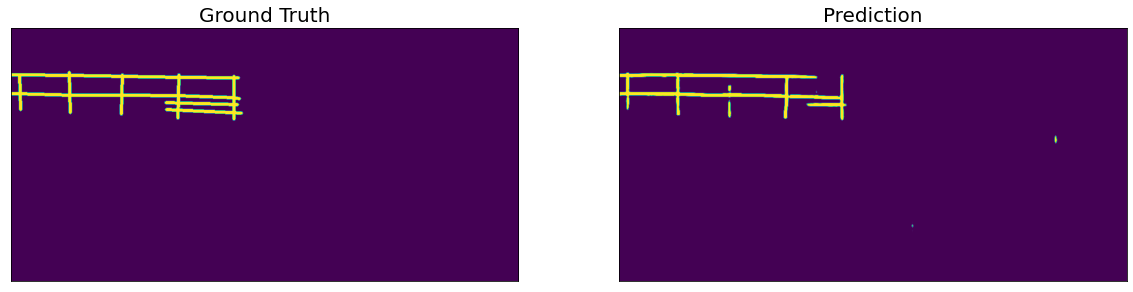

In [4]:
from utils.metrics import box_precision

box_precision(mask, pred)
visualize(ground_truth=mask,
          prediction=pred)